In [1]:
def get_files_of_type(parent_path:str, filetype:str, as_dict:bool=False) :

    assert os.path.isdir(parent_path), f'{parent_path} is not a valid directory.'

    path_list = sorted([os.path.join(root,file)
                        for root,_,files in os.walk(parent_path)
                        for file in files if file.endswith(filetype)])

    assert len(path_list) > 0, f'{parent_path} contains 0 files of file type {filetype}.'
    
    if as_dict :
        
        path_dict = {".".join(os.path.split(path)[-1].split(".")[:-1]):path for path in path_list}

        return path_dict

    return path_list
    
# Helper function convert any column with header with substring "time" to pandas.datetime
# Taken from Young Sang Choi
def dataframe_datetime(df) :
    
    for c in [c for c in df.columns if 'time' in c] :

        try :
            df[c] = pd.to_datetime(df[c])
        except Exception :
            pass

    return df

In [2]:
import pandas as pd
import gc

# Import icu stays records 
icustays_df = pd.read_csv('/kaggle/input/data-icu/icustays.csv',low_memory=True)
# Import hospital admissions records
admissions_df = pd.read_csv('/kaggle/input/data-icu/admissions.csv',low_memory=True)
# Use atetime conversion
icustays_df = dataframe_datetime(icustays_df)
admissions_df = dataframe_datetime(admissions_df)

# Check that all hadm_ids for icu stays table are in the admissions table
assert set(icustays_df['hadm_id']).issubset(set(admissions_df['hadm_id']))

In [3]:
icustays_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [4]:
admissions_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [5]:
import numpy as np 
# Keep icustays with lengths of stay greater or equal to 1 day (taken from admissions_df)
icustays_df = icustays_df[icustays_df['los'] >= 1]
icu_hadm_ids = set(icustays_df['hadm_id']) & set(admissions_df['hadm_id'])
admissions_df = admissions_df[admissions_df['hadm_id'].isin(icu_hadm_ids)]
subjects = set(admissions_df['subject_id'])
stays = set(icustays_df['stay_id'])
#print(f'{icustays_df.shape=}')

In [6]:
# Obtain patient age (based on HIPAA regulations) and gender - gender, 1=female, 0=male
# Adapted from Young Sang Choi
patients_df = pd.read_csv('/kaggle/input/data-icu/patients.csv')
patients_df = patients_df[patients_df['subject_id'].isin(subjects)]
patients_df['gender'] = np.array(patients_df['gender'] == 'F').astype(int)
anchor_age_tuples = patients_df.apply(lambda row : (row['subject_id'], row['anchor_age'], row['anchor_year']), 1)
anchor_age_dict = {subject_id:{'anchor_age':anchor_age, 'anchor_year':anchor_year} for subject_id,anchor_age,anchor_year in anchor_age_tuples}
gender_dict = dict(zip(patients_df['subject_id'], patients_df['gender']))
icustays_df['age'] = icustays_df.apply(lambda row : anchor_age_dict[row['subject_id']]['anchor_age'] + (row['intime'].year - anchor_age_dict[row['subject_id']]['anchor_year']), 1)
icustays_df['age'] = icustays_df.apply(lambda row : row['age'] if row['age'] <= 90 else 90, 1) # HIPAA deidentification rule
icustays_df['gender'] = icustays_df.apply(lambda row: gender_dict[row['subject_id']], 1)

In [7]:
# Add insurance and admission location to each subject_id in icustays_df
# Adapted from Young Sang Choi
admissions_df = admissions_df[admissions_df['subject_id'].isin(subjects)]
insurance_dict = dict(zip(admissions_df['subject_id'], admissions_df['insurance']))
icustays_df['insurance'] = icustays_df['subject_id'].map(insurance_dict)
admloc_dict = dict(zip(admissions_df['subject_id'], admissions_df['admission_location']))
icustays_df['admission location'] = icustays_df['subject_id'].map(admloc_dict)
race_dict = dict(zip(admissions_df['subject_id'], admissions_df['race']))
icustays_df['race'] = icustays_df['subject_id'].map(race_dict)


In [8]:
# Delete tuples not needed anymore
del anchor_age_tuples
del anchor_age_dict
del gender_dict

In [9]:
import os
# Import vitals table (chartevents)
# Adapted from Young Sang Choi
chartevent_definitions = pd.read_csv('/kaggle/input/data-icu/d_items.csv',low_memory=True)
chartevent_definitions = chartevent_definitions[(chartevent_definitions['linksto'] == 'chartevents') & (chartevent_definitions['category'] == 'Routine Vital Signs')]
routine_vital_items = chartevent_definitions['itemid'].values
print(f'Number of unique routine vital sign item ids: {len(routine_vital_items)}')

chartevents = pd.read_csv('/kaggle/input/data-icu/chartevents.csv', chunksize = 10000000)
icu_stay_ids = set(icustays_df['stay_id'])
subjects = set(icustays_df['subject_id'])


for p in [os.path.join('.', 'data'), os.path.join('.', 'data', 'mimic_chartevents')] :
    if not os.path.isdir(p) :
        os.mkdir(p)

mimic_chartevents_parent = os.path.join('.', 'data', 'mimic_chartevents')

if len(os.listdir(mimic_chartevents_parent)) == 0 : 

    for i,chunk in enumerate(chartevents) : 
        
        original_size = chunk.shape
        chunk = chunk[(chunk['stay_id'].isin(icu_stay_ids)) & (chunk['itemid'].isin(routine_vital_items))]
        chunk.to_csv(os.path.join(mimic_chartevents_parent, f'mimic_vitals_{i}.csv'), index = False)
        print(f'Chunk {i}: selected {chunk.shape[0]} from {original_size[0]} rows.')

chartevents_df = pd.concat([pd.read_csv(path) for path in get_files_of_type(mimic_chartevents_parent, filetype = 'csv')], axis=0, ignore_index=True)
chartevents_df.reset_index(drop = True, inplace = True)
chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])

#print(f'{chartevents_df.shape=}')

# Group the chartevents_df by 'stay_id' and 'itemid', and keep the first row for each group - first vital signs for each patient
filtered_chartevents_df = chartevents_df.groupby(['stay_id', 'itemid']).first().reset_index()
#print(f'{filtered_chartevents_df.shape=}')

Number of unique routine vital sign item ids: 50
Chunk 0: selected 1303949 from 10000000 rows.
Chunk 1: selected 1293131 from 10000000 rows.
Chunk 2: selected 1295828 from 10000000 rows.
Chunk 3: selected 1324882 from 10000000 rows.
Chunk 4: selected 1302325 from 10000000 rows.
Chunk 5: selected 1291847 from 10000000 rows.
Chunk 6: selected 1280401 from 10000000 rows.
Chunk 7: selected 1295091 from 10000000 rows.
Chunk 8: selected 1303887 from 10000000 rows.
Chunk 9: selected 1295437 from 10000000 rows.
Chunk 10: selected 1306224 from 10000000 rows.
Chunk 11: selected 1323810 from 10000000 rows.
Chunk 12: selected 1313390 from 10000000 rows.
Chunk 13: selected 1297758 from 10000000 rows.
Chunk 14: selected 1288797 from 10000000 rows.
Chunk 15: selected 1287845 from 10000000 rows.
Chunk 16: selected 1303790 from 10000000 rows.
Chunk 17: selected 1291729 from 10000000 rows.
Chunk 18: selected 1298391 from 10000000 rows.
Chunk 19: selected 1289437 from 10000000 rows.
Chunk 20: selected 12

In [10]:
# Merge the chartevents and icustay DataFrames based on the condition
filtered_chartevents_df = pd.merge(
    filtered_chartevents_df,
    icustays_df,
    how='inner',
    on=['stay_id','subject_id','hadm_id']
)
#filtered_chartevents_df.rename(columns={'stay_id_x': 'stay_id'}, inplace=True)

In [11]:
import pandas as pd
# Obtain labevents table for all patients in cohort
labs_df = pd.read_csv('/kaggle/input/data-icu/labevents.csv',low_memory=True)
labs_df = labs_df[labs_df['subject_id'].isin(subjects)]
labs_df = dataframe_datetime(labs_df)
print(f'{labs_df.shape=}')

labs_df.shape=(54670983, 15)


In [12]:
# Merge the DataFrames based on the condition
filtered_labs_df = pd.merge(
    labs_df,
    icustays_df,
    how='inner',
    left_on=['subject_id', 'hadm_id'],
    right_on=['subject_id', 'hadm_id']
)

filtered_labs_df['charttime'] = pd.to_datetime(filtered_labs_df['charttime'])

# Filter rows where 'charttime' is between 'intime' and 'outtime'
condition = (filtered_labs_df['charttime'] >= filtered_labs_df['intime']) & (filtered_labs_df['charttime'] <= filtered_labs_df['outtime'])
filtered_labs_df.loc[condition, 'stay_id'] = filtered_labs_df.loc[condition, 'stay_id']

# Display the resulting DataFrame
#print(filtered_labs_df[['subject_id','hadm_id','stay_id','itemid','valuenum']])
#print(f'{filtered_labs_df.shape=}')

In [13]:
# Clean and convert the 'value' column to numeric
filtered_labs_df['value'] = pd.to_numeric(filtered_labs_df['value'], errors='coerce')

# Check for duplicate itemid within each stay_id group
duplicates_for_stay_id = filtered_labs_df[filtered_labs_df.duplicated(subset=['stay_id', 'itemid'], keep=False)]

# Calculate the average value for duplicate itemid within each stay_id group
averages_for_duplicates = duplicates_for_stay_id.groupby(['stay_id', 'itemid'])['value'].mean().reset_index()

# Merge the calculated averages back into the original DataFrame
filtered_labs_df = pd.merge(filtered_labs_df, averages_for_duplicates, how='left', on=['stay_id', 'itemid'], suffixes=('', '_avg'))

# Fill NaN values in the original 'value' column with the calculated averages
filtered_labs_df['value'].fillna(filtered_labs_df['value_avg'], inplace=True)

# Drop the redundant 'value_avg' column
filtered_labs_df.drop(columns=['value_avg'], inplace=True)

/tmp/ipykernel_13/2115429337.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_labs_df['value'].fillna(filtered_labs_df['value_avg'], inplace=True)


In [14]:

import pandas as pd
pharm_df = pd.read_csv('/kaggle/input/data-icu/prescriptions.csv',low_memory=True)
# Merge the DataFrames based on the condition
filtered_pharm_df = pd.merge(
    pharm_df,
    icustays_df,
    how='inner',
    left_on=['subject_id', 'hadm_id'],
    right_on=['subject_id', 'hadm_id']
)

filtered_pharm_df['starttime'] = pd.to_datetime(filtered_pharm_df['starttime'])

# Filter rows where 'charttime' is between 'intime' and 'outtime'
condition = (filtered_pharm_df['starttime'] >= filtered_pharm_df['intime']) & (filtered_pharm_df['starttime'] <= filtered_pharm_df['outtime'])
filtered_pharm_df.loc[condition, 'stay_id'] = filtered_pharm_df.loc[condition, 'stay_id']

# Display the resulting DataFrame
#print(filtered_pharm_df[['subject_id','hadm_id','stay_id','drug']])
#print(f'{filtered_pharm_df.shape=}')

In [15]:
# Create dataframes for analysis
analysis_chartevents_df = filtered_chartevents_df[['stay_id', 'subject_id', 'itemid', 'valuenum','insurance','gender','age','race']]
analysis_labs_df = filtered_labs_df[['subject_id', 'stay_id', 'itemid', 'value','insurance','gender','age','race']]
analysis_pharm_df = filtered_pharm_df[['subject_id', 'stay_id', 'drug','insurance','gender','age','race']]

In [16]:
# Only keep columns needed for each dataframe 
_chartevents_df = filtered_chartevents_df[['stay_id', 'subject_id', 'itemid', 'valuenum']]
_labs_df = filtered_labs_df[['subject_id', 'stay_id', 'itemid', 'value']]
_pharm_df = filtered_pharm_df[['subject_id', 'stay_id', 'drug']]

In [17]:
# Replace item_id values with names to be more legible 

d_items = pd.read_csv('/kaggle/input/data-icu/d_items.csv',low_memory=True)
# Create a dictionary mapping itemid to label from chartevent_definitions
itemid_to_label = d_items.set_index('itemid')['label'].to_dict()
# In-place replace the itemid column with label
_chartevents_df['itemid'] = _chartevents_df['itemid'].map(itemid_to_label)

# Create a dictionary mapping itemid to label from d_labitems
d_labitems = pd.read_csv('/kaggle/input/data-icu/d_labitems.csv',low_memory=True)
itemid_to_label = d_labitems.set_index('itemid')['label'].to_dict()
# In-place replace the itemid column with label
_labs_df['itemid'] = _labs_df['itemid'].map(itemid_to_label)

/tmp/ipykernel_13/2678398787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _chartevents_df['itemid'] = _chartevents_df['itemid'].map(itemid_to_label)
/tmp/ipykernel_13/2678398787.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _labs_df['itemid'] = _labs_df['itemid'].map(itemid_to_label)


In [18]:
# Pivot the DataFrame without itemid and fill NaN with 0
final_chartevents = _chartevents_df.pivot_table(
    index=['subject_id', 'stay_id'],
    columns='itemid',
    values='valuenum',
    fill_value=0  # Replace NaN with 0
)

# Reset the index if needed
final_chartevents = final_chartevents.reset_index()

# Display the resulting DataFrame
#final_chartevents.head(1)

In [19]:
# Convert 'value' column to numeric, coerce non-numeric values to NaN
_labs_df['value'] = pd.to_numeric(_labs_df['value'], errors='coerce')

# Pivot the DataFrame without itemid and fill NaN with 0
final_labs = _labs_df.pivot_table(
    index=['subject_id', 'stay_id'],
    columns='itemid',
    values='value',
    fill_value=0  # Replace NaN with 0
)

# Reset the index if needed
final_labs = final_labs.reset_index()

# Display the resulting DataFrame
#final_labs.head(1)

/tmp/ipykernel_13/642826982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _labs_df['value'] = pd.to_numeric(_labs_df['value'], errors='coerce')


In [20]:
# Create a new column 'value' and set it to 1 for all rows
_pharm_df['value'] = 1

# Pivot the DataFrame
final_pharm = _pharm_df.pivot_table(index=['subject_id', 'stay_id'], columns='drug', values='value', fill_value=0)

# Reset the index if needed
final_pharm = final_pharm.reset_index()
#final_pharm.head(5)

/tmp/ipykernel_13/4182629100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _pharm_df['value'] = 1


In [21]:
# Merge the first two pivoted DataFrames
icu_data = pd.merge(icustays_df, final_chartevents, on=['subject_id', 'stay_id'], how='inner')

# Merge the third pivoted DataFrame
icu_data = pd.merge(icu_data, final_labs, on=['subject_id', 'stay_id'], how='inner')

# Merge the icustays_df DataFrame
icu_data = pd.merge(icu_data, final_pharm, on=['subject_id', 'stay_id'], how='inner')

# Display the resulting DataFrame
icu_data.head(5)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zafirlukast,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,46,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,57,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
print(icu_data['stay_id'].nunique())

57487


In [23]:
# Mapping dictionary for race renaming
race_mapping = {
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'UNKNOWN': 'OTHER',
    'UNABLE TO OBTAIN': 'OTHER',
    'PATIENT DECLINED TO ANSWER': 'OTHER',
    'WHITE - RUSSIAN': 'WHITE',
    'PORTUGUESE': 'WHITE',
    'WHITE - BRAZILIAN': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE', 
    'BLACK/CAPE VERDEAN':'BLACK/AFRICAN AMERICAN',
    'BLACK/AFRICAN':'BLACK/AFRICAN AMERICAN',
    'BLACK/CARIBBEAN ISLAND':'BLACK/AFRICAN AMERICAN',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
    'HISPANIC OR LATINO': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO',
    'SOUTH AMERICAN': 'HISPANIC/LATINO',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'PACIFIC ISLANDER',
    'AMERICAN INDIAN/ALASKA NATIVE': 'PACIFIC ISLANDER',
    'NATIVE HAWAIIAN/PACIFIC ISLANDER': 'PACIFIC ISLANDER'
    
}
# Replace values in the 'race' column using the mapping dictionary for all dataframes 
icu_data['race'] = icu_data['race'].replace(race_mapping)
analysis_chartevents_df['race'] = analysis_chartevents_df['race'].replace(race_mapping)
analysis_labs_df['race'] = analysis_labs_df['race'].replace(race_mapping)
analysis_pharm_df['race'] = analysis_pharm_df['race'].replace(race_mapping)


/tmp/ipykernel_13/3883236305.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_chartevents_df['race'] = analysis_chartevents_df['race'].replace(race_mapping)
/tmp/ipykernel_13/3883236305.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_labs_df['race'] = analysis_labs_df['race'].replace(race_mapping)
/tmp/ipykernel_13/3883236305.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [24]:
# Shape of the cleaned data
print(icu_data.shape[0])
print(icu_data.shape[1])

57487
5074


In [25]:
# Export csv file with all the cleaned data
icu_data.to_csv('icu_data_Nolm.csv', index=False)

# Dataset Stadistics

In [26]:
import pandas as pd

icu_data = pd.read_csv('/kaggle/working/icu_data_Nolm.csv',low_memory=True)
icu_stays = pd.read_csv('/kaggle/input/data-icu/icustays.csv', low_memory=True)
admissions = pd.read_csv('/kaggle/input/data-icu/admissions.csv',low_memory=True)
patients = pd.read_csv('/kaggle/input/data-icu/patients.csv', low_memory=True)

In [27]:
def percentage(df, column, condition):

    condition_number = len(df.loc[df[column]==condition])
    result = condition_number / len(df)
    
    return result

In [28]:
icu_stays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

In [29]:
admissions['insurance'].unique()

array(['Other', 'Medicaid', 'Medicare'], dtype=object)

In [30]:
percentage(admissions, 'insurance', 'Other')

0.5320676984745574

In [31]:

icu_data['hadm_id'].nunique()

52781

In [32]:
icu_stays['hadm_id'].loc[icu_stays['los']>1].nunique()

52988

In [33]:
len(icu_data[icu_data['age'] >= 18])

57487

In [34]:
analysis_labs_df.head(1)

,subject_id,stay_id,itemid,value,insurance,gender,age,race
0,10001217,37067082,51790,59.0,Other,1,55,WHITE


# Data Visualizations for Disparities in Data

## Fig. 1: Depiction of Race breakdown

### (a) Average number of medications per ICU stay

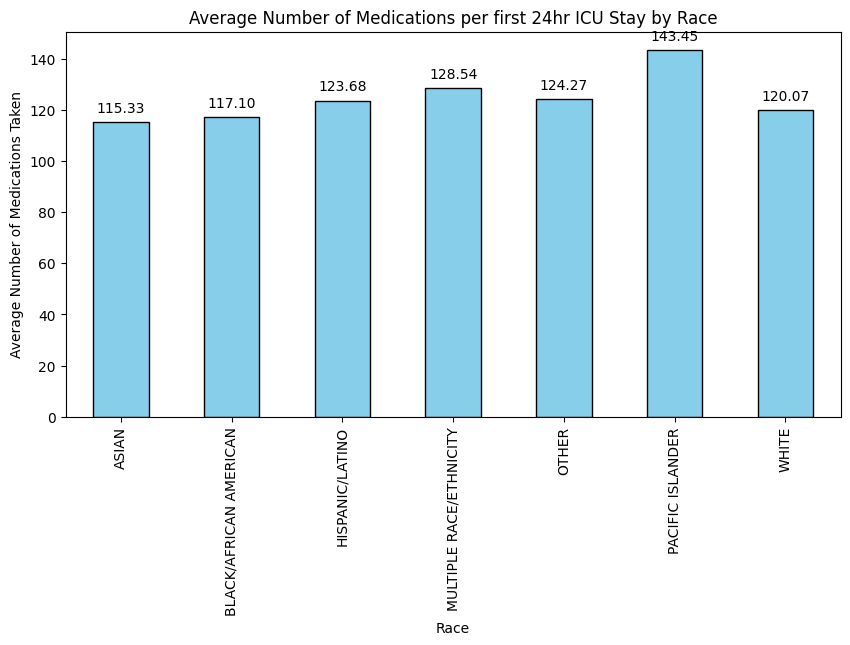

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called analysis_chartevents_df

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_pharm = analysis_pharm_df.groupby(['stay_id', 'race']).size().reset_index(name='pharm_count').groupby('race')['pharm_count'].mean()

# Plotting the bar chart
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medications per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Medications Taken')
plt.show()

### (b) average number of labs per ICU stay

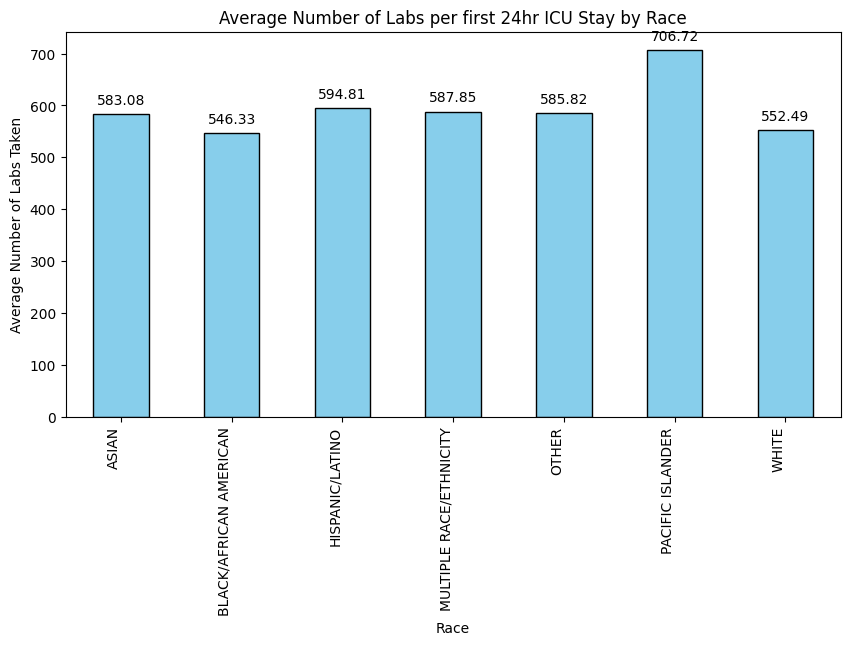

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called analysis_chartevents_df

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_labs = analysis_labs_df.groupby(['stay_id', 'race']).size().reset_index(name='labs_count').groupby('race')['labs_count'].mean()

# Plotting the bar chart
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Labs Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

### (c) average number of vitals per ICU stay

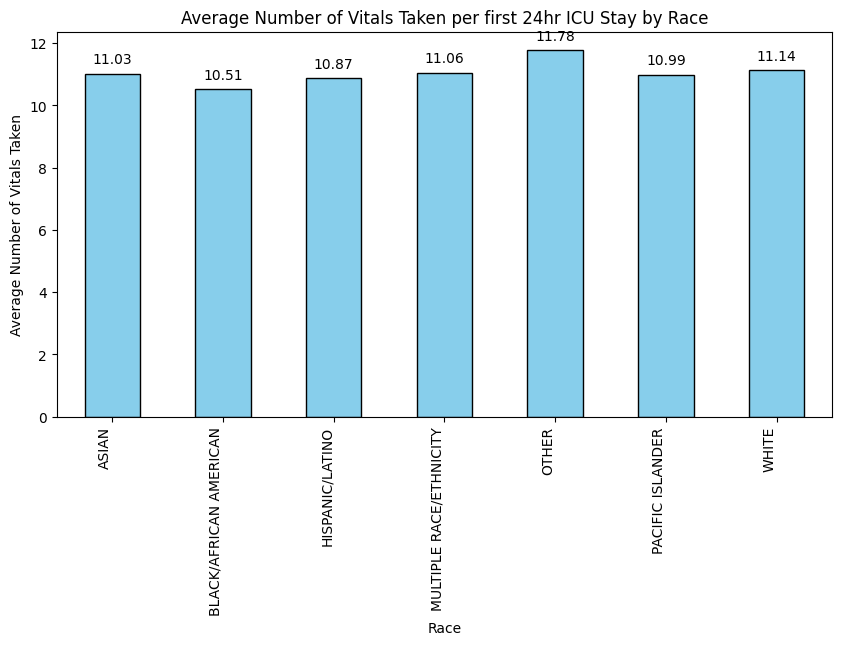

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'race']).size().reset_index(name='chartevents_count').groupby('race')['chartevents_count'].mean()

# Plotting the bar chart
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

## Fig. 2: Depiction of gender breakdown

### (a) The average number of medications per ICU stay

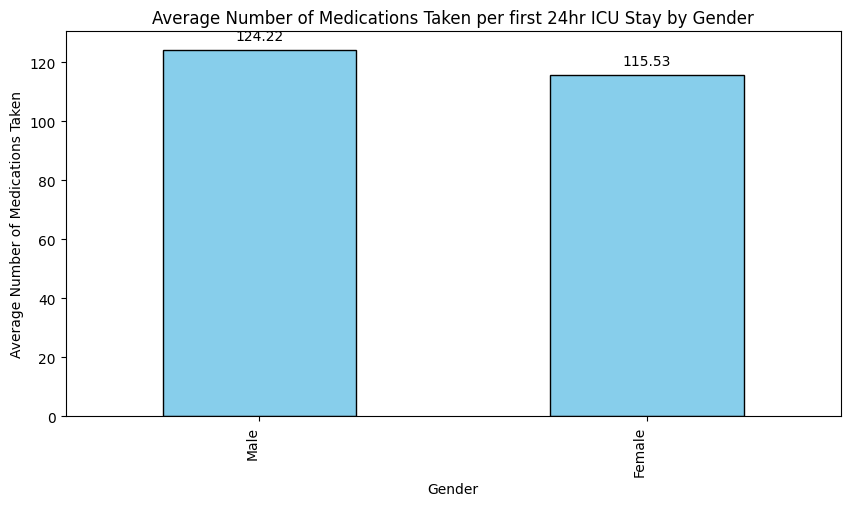

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called analysis_chartevents_df

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_pharm = analysis_pharm_df.groupby(['stay_id', 'gender']).size().reset_index(name='pharm_count').groupby('gender')['pharm_count'].mean()

# Plotting the bar chart
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medications Taken per first 24hr ICU Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Medications Taken')
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')
plt.show()

### b) the average number of labs per ICU stay

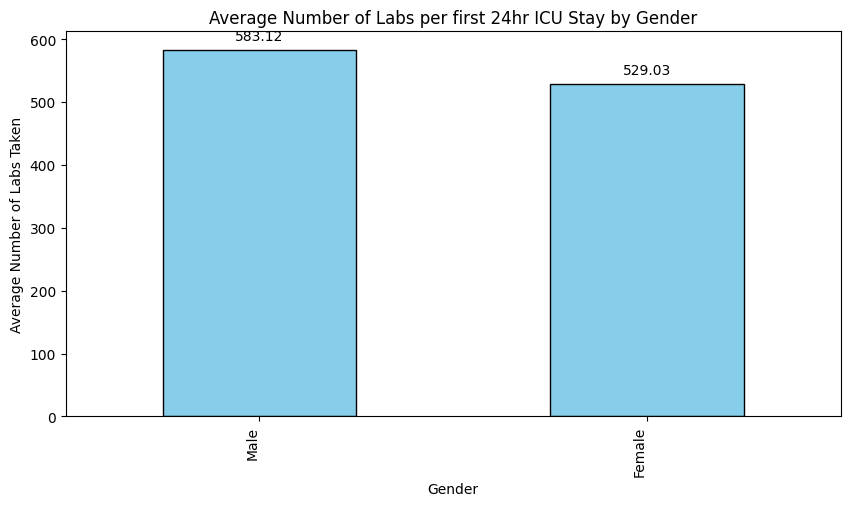

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of labs
average_labs = analysis_labs_df.groupby(['stay_id', 'gender']).size().reset_index(name='labs_count').groupby('gender')['labs_count'].mean()

# Plotting the bar chart
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Labs Taken')
# Combine rotation and custom labels
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')

plt.show()

### (c) the average number of vitals per ICU stay

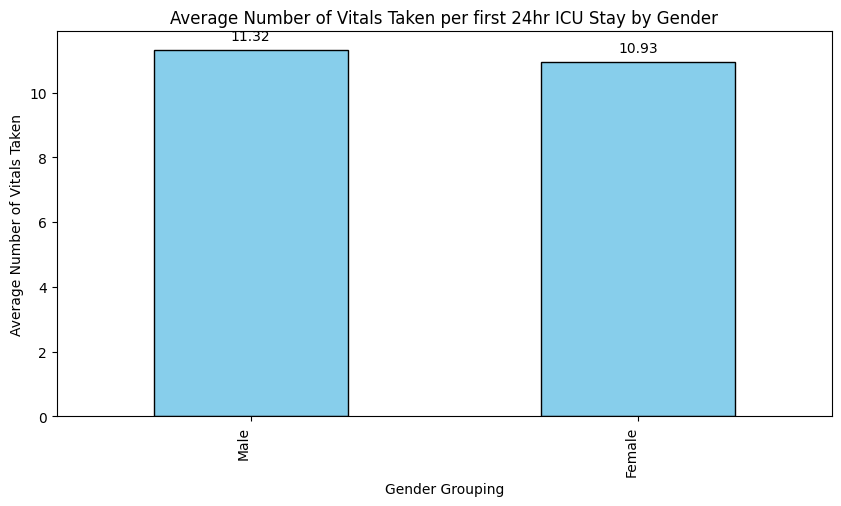

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'gender']).size().reset_index(name='chartevents_count').groupby('gender')['chartevents_count'].mean()

# Plotting the bar chart
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Gender')
plt.xlabel('Gender Grouping')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')
plt.show()

## Fig. 3: Depiction of insurance breakdown

### (a) Average number of medications per ICU stay

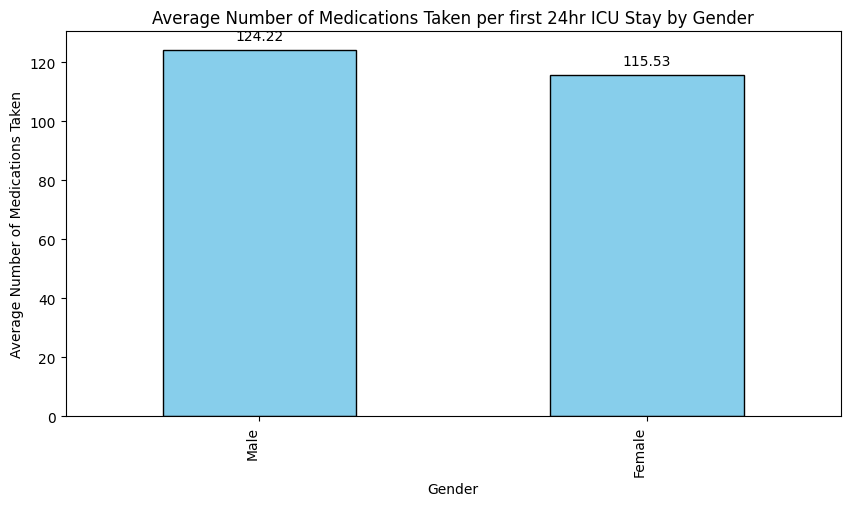

In [41]:
# Assuming you have a DataFrame called analysis_chartevents_df

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_pharm = analysis_pharm_df.groupby(['stay_id', 'gender']).size().reset_index(name='pharm_count').groupby('gender')['pharm_count'].mean()

# Plotting the bar chart
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medications Taken per first 24hr ICU Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Medications Taken')
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')
plt.show()

### (b) average number of labs per ICU stay

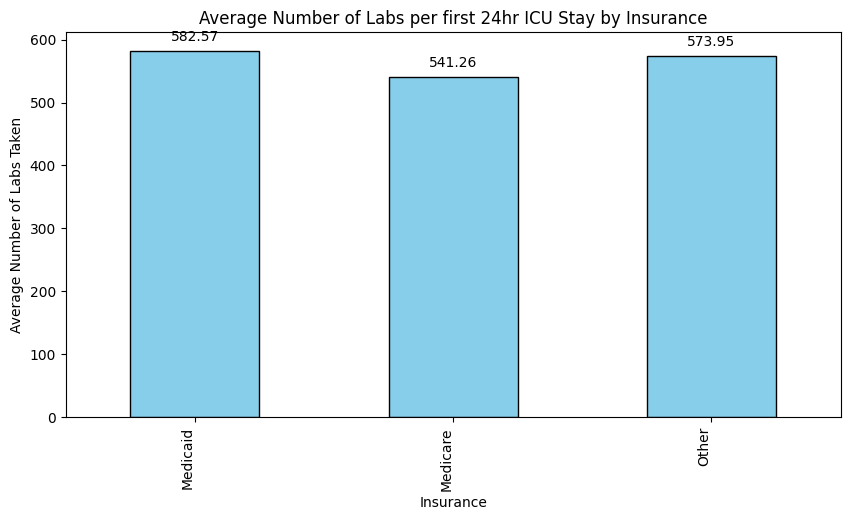

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_labs = analysis_labs_df.groupby(['stay_id', 'insurance']).size().reset_index(name='labs_count').groupby('insurance')['labs_count'].mean()

# Plotting the bar chart
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Insurance')
plt.xlabel('Insurance')
plt.ylabel('Average Number of Labs Taken')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()


### (c) average number of vitals per ICU stay

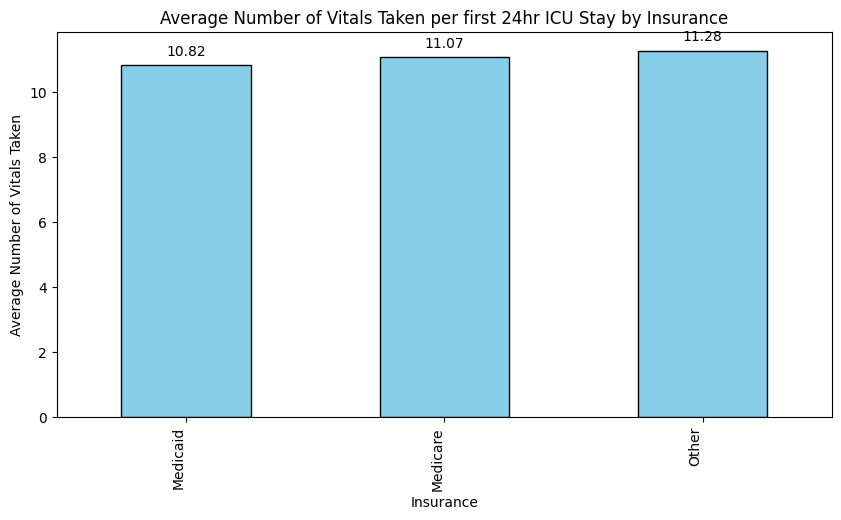

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'stay_id' and 'insurance_grouping' and calculate the average number of chart events
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'insurance']).size().reset_index(name='chartevents_count').groupby('insurance')['chartevents_count'].mean()

# Plotting the bar chart
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Insurance')
plt.xlabel('Insurance')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

## Fig. 4: Length of ICU Stay by Insurance and Race

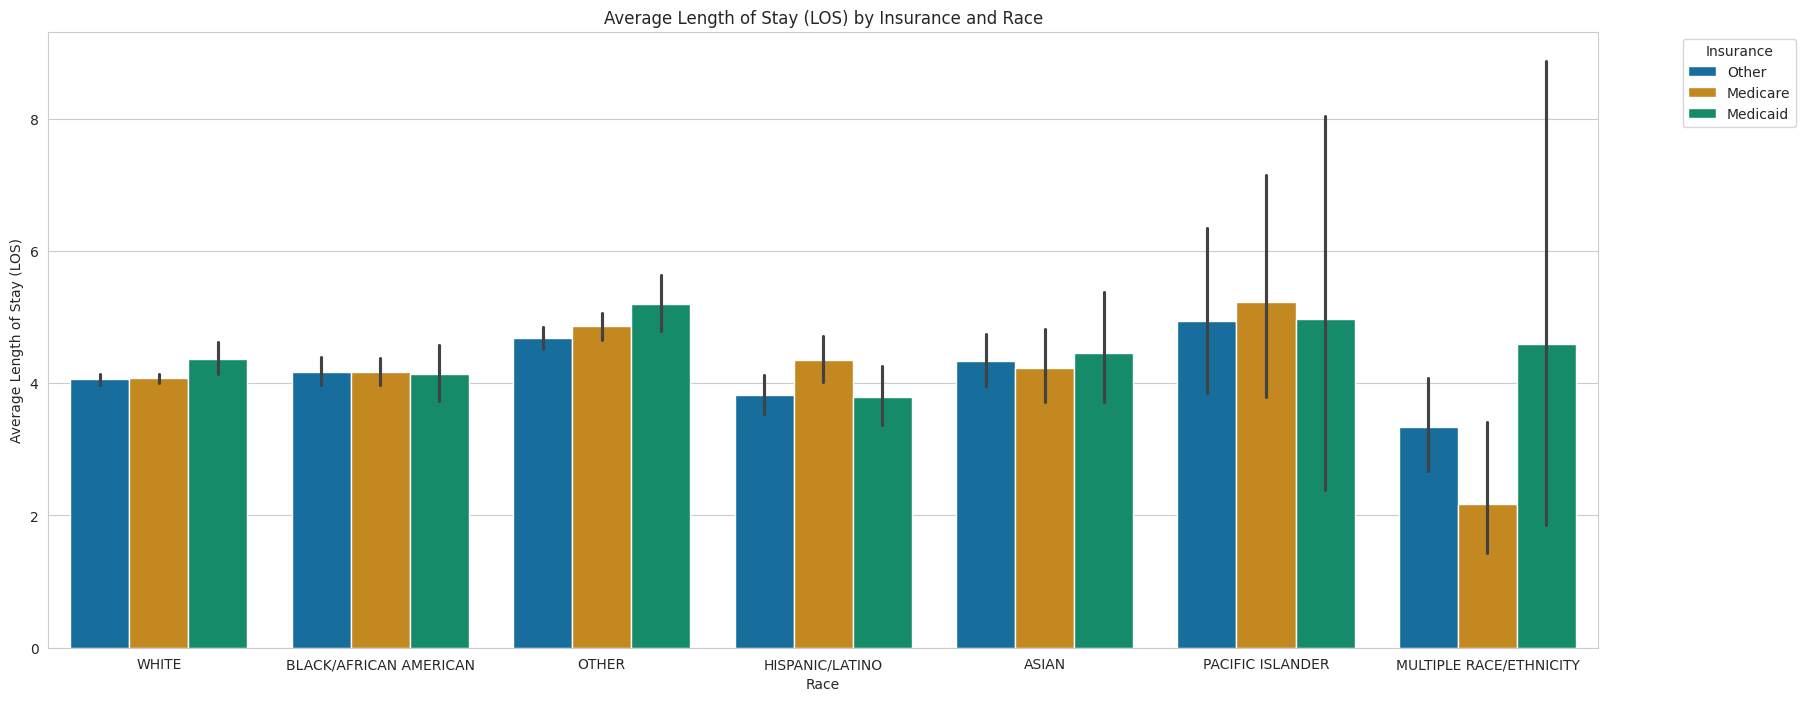

In [44]:
import seaborn as sns
# Assuming you have a DataFrame called icu_data

# Set seaborn style to whitegrid
sns.set_style("whitegrid")

# Plotting the grouped bar plot for average LOS
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='race', y='los', hue='insurance', data=icu_data, palette='colorblind', estimator=np.mean)

plt.title('Average Length of Stay (LOS) by Insurance and Race')
plt.xlabel('Race')
plt.ylabel('Average Length of Stay (LOS)')

plt.legend(title='Insurance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

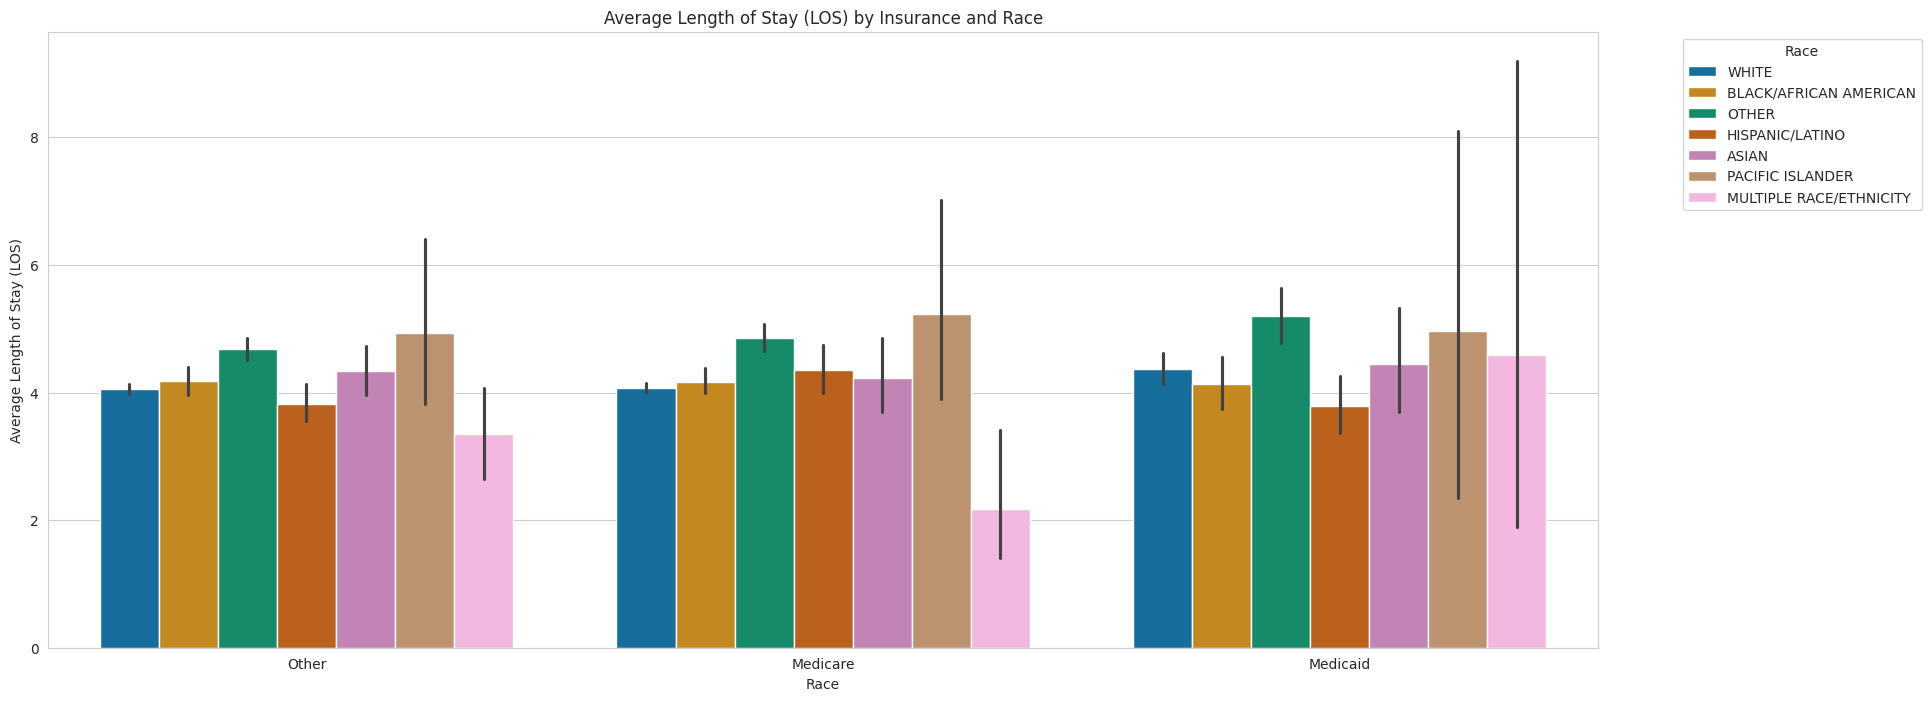

In [45]:
# Assuming you have a DataFrame called icu_data

# Set seaborn style to whitegrid
sns.set_style("whitegrid")

# Plotting the grouped bar plot for average LOS
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='insurance', y='los', hue='race', data=icu_data, palette='colorblind', estimator=np.mean)

plt.title('Average Length of Stay (LOS) by Insurance and Race')
plt.xlabel('Race')
plt.ylabel('Average Length of Stay (LOS)')

plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ANOVA ANALYSIS

In [46]:
grouped_data = icu_data.groupby(['gender', 'insurance', 'race'])['los'].mean()

# To calculate median instead of mean, use the following:
# grouped_data = icustays_df.groupby(['gender', 'insurance', 'race'])['los'].median()

# Displaying the grouped data
print(grouped_data)

gender  insurance  race                   
0       Medicaid   ASIAN                      4.195222
                   BLACK/AFRICAN AMERICAN     3.893657
                   HISPANIC/LATINO            3.948069
                   MULTIPLE RACE/ETHNICITY    6.815738
                   OTHER                      5.459344
                   PACIFIC ISLANDER           4.595108
                   WHITE                      4.185528
        Medicare   ASIAN                      4.543924
                   BLACK/AFRICAN AMERICAN     4.308302
                   HISPANIC/LATINO            4.403449
                   MULTIPLE RACE/ETHNICITY    3.338974
                   OTHER                      4.792551
                   PACIFIC ISLANDER           5.316365
                   WHITE                      4.190309
        Other      ASIAN                      4.731332
                   BLACK/AFRICAN AMERICAN     4.260432
                   HISPANIC/LATINO            3.767169
                   MUL

In [47]:
from scipy.stats import f_oneway

# Assuming 'icustays_df' is your DataFrame
# Performing one-way ANOVA test for 'gender'
anova_gender = f_oneway(*[group['los'].values for name, group in icu_data.groupby('gender')])

# Performing one-way ANOVA test for 'insurance'
anova_insurance = f_oneway(*[group['los'].values for name, group in icu_data.groupby('insurance')])

# Performing one-way ANOVA test for 'race'
anova_race = f_oneway(*[group['los'].values for name, group in icu_data.groupby('race')])

# Displaying the ANOVA results
print("ANOVA for Gender:")
print(anova_gender)

print("\nANOVA for Insurance:")
print(anova_insurance)

print("\nANOVA for Race:")
print(anova_race)

ANOVA for Gender:
F_onewayResult(statistic=9.384710259185336, pvalue=0.002189038185707358)

ANOVA for Insurance:
F_onewayResult(statistic=3.769883218111512, pvalue=0.023060455640155294)

ANOVA for Race:
F_onewayResult(statistic=22.11270216736019, pvalue=3.771858109994944e-26)


# Model XGBOOST - Replication

In [48]:
condition = (icu_data['los'] > 4).map({True: 'Long', False: 'Short'})

# Create a new column 'los_type' based on the condition
icu_data['los_type'] = condition

In [49]:
# Split data into training and validation data
from sklearn.model_selection import train_test_split

# Assuming 'subject_id' is the patient identifier
patient_ids = icu_data['subject_id'].unique()

# Split patient_ids into training and testing sets
train_patient_ids, validation_patient_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Filter the dataframe based on the split of patient_ids
train_data = icu_data[icu_data['subject_id'].isin(train_patient_ids)]
validation_data = icu_data[icu_data['subject_id'].isin(validation_patient_ids)]

# Check the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Validation set shape:", validation_data.shape)

Training set shape: (45901, 5075)
Validation set shape: (11586, 5075)


In [50]:
train_insurance_counts =train_data['insurance'].value_counts()
print("Train Data Insurance Counts:")
print(train_insurance_counts)

validation_insurance_counts =validation_data['insurance'].value_counts()
print("Validation Data Insurance Counts:")
print(validation_insurance_counts)

train_race_counts =train_data['race'].value_counts()
print("Train Data Race Counts:")
print(train_race_counts)

validation_race_counts =validation_data['race'].value_counts()
print("Validation Data Race Counts:")
print(validation_race_counts)

train_duration_counts =train_data['los_type'].value_counts()
print("Train Data LOS Counts:")
print(train_duration_counts)

validation_duration_counts =validation_data['los_type'].value_counts()
print("Validation Data LOS Counts:")
print(validation_duration_counts)

Train Data Insurance Counts:
insurance
Other       21567
Medicare    21039
Medicaid     3295
Name: count, dtype: int64
Validation Data Insurance Counts:
insurance
Other       5393
Medicare    5300
Medicaid     893
Name: count, dtype: int64
Train Data Race Counts:
race
WHITE                      31432
OTHER                       6522
BLACK/AFRICAN AMERICAN      4688
HISPANIC/LATINO             1731
ASIAN                       1335
PACIFIC ISLANDER             148
MULTIPLE RACE/ETHNICITY       45
Name: count, dtype: int64
Validation Data Race Counts:
race
WHITE                      7861
OTHER                      1608
BLACK/AFRICAN AMERICAN     1284
HISPANIC/LATINO             423
ASIAN                       355
PACIFIC ISLANDER             48
MULTIPLE RACE/ETHNICITY       7
Name: count, dtype: int64
Train Data LOS Counts:
los_type
Short    32710
Long     13191
Name: count, dtype: int64
Validation Data LOS Counts:
los_type
Short    8302
Long     3284
Name: count, dtype: int64


In [51]:
# Assuming 'subject_id' is the patient identifier
patient_ids_train = train_data['subject_id'].unique()

# Split patient_ids_train into training and testing sets
train_train_ids, test_train_ids = train_test_split(patient_ids_train, test_size=0.2, random_state=42)

# Filter the train_data based on the split of patient_ids_train
train_train_data = train_data[train_data['subject_id'].isin(train_train_ids)]
test_train_data = train_data[train_data['subject_id'].isin(test_train_ids)]

# Check the shapes of the training and testing sets
print("Train Training set shape:", train_train_data.shape)
print("Train Testing set shape:", test_train_data.shape)

Train Training set shape: (36738, 5075)
Train Testing set shape: (9163, 5075)


In [52]:
!pip install xgboost
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Convert probability scores to binary predictions using a threshold
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Generate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 3.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


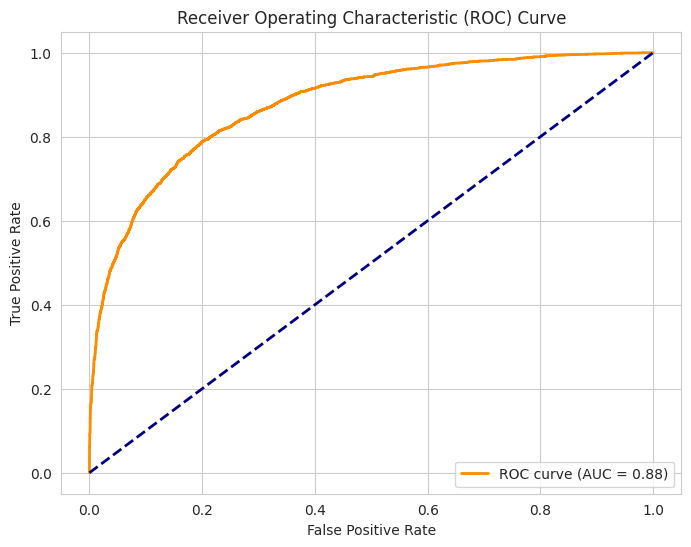

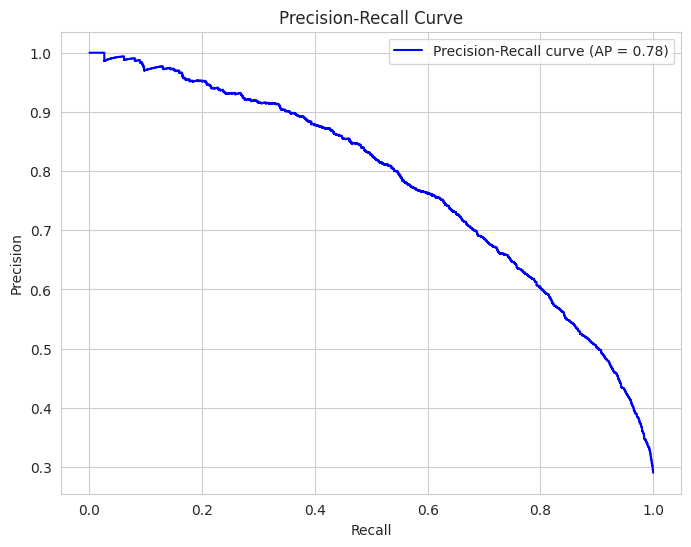

Area under ROC curve (AUC-ROC): 0.88
Area under Precision-Recall curve (AUC-PR): 0.78


In [53]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

print(f'Area under ROC curve (AUC-ROC): {roc_auc:.2f}')
print(f'Area under Precision-Recall curve (AUC-PR): {average_precision:.2f}')

In [54]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[6005  499]
 [1064 1595]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6504
           1       0.76      0.60      0.67      2659

    accuracy                           0.83      9163
   macro avg       0.81      0.76      0.78      9163
weighted avg       0.82      0.83      0.82      9163



In [55]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Extract insurance information for the test set
insurance_test = train_data.loc[y_test.index, 'insurance']

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Combine predictions and insurance information into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Insurance': insurance_test})

# Assess performance for each insurance type
insurance_types = results_df['Insurance'].unique()
for insurance_type in insurance_types:
    subset = results_df[results_df['Insurance'] == insurance_type]
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {insurance_type} insurance:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for Medicare insurance:
Confusion Matrix:
[[2748  237]
 [ 533  739]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2985
           1       0.76      0.58      0.66      1272

    accuracy                           0.82      4257
   macro avg       0.80      0.75      0.77      4257
weighted avg       0.81      0.82      0.81      4257


--------------------------------------------------

Results for Other insurance:
Confusion Matrix:
[[2832  224]
 [ 463  716]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3056
           1       0.76      0.61      0.68      1179

    accuracy                           0.84      4235
   macro avg       0.81      0.77      0.78      4235
weighted avg       0.83      0.84      0.83      4235


--------------------------------------------------

Results for Medicaid insurance:
Confusion

In [56]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Extract insurance information for the test set
race_test = train_data.loc[y_test.index, 'race']

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Combine predictions and insurance information into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Race': race_test})

# Get unique race types
race_types = results_df['Race'].unique()
# Assess performance for each race type
for race_type in race_types:
    subset = results_df[results_df['Race'] == race_type]
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {race_type} race:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for WHITE race:
Confusion Matrix:
[[4186  331]
 [ 731 1014]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4517
           1       0.75      0.58      0.66      1745

    accuracy                           0.83      6262
   macro avg       0.80      0.75      0.77      6262
weighted avg       0.82      0.83      0.82      6262


--------------------------------------------------

Results for OTHER race:
Confusion Matrix:
[[778  80]
 [123 295]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       858
           1       0.79      0.71      0.74       418

    accuracy                           0.84      1276
   macro avg       0.83      0.81      0.81      1276
weighted avg       0.84      0.84      0.84      1276


--------------------------------------------------

Results for BLACK/AFRICAN AMERICAN race:
Confusion Matrix:

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [57]:
def equalized_odds(y_true, y_pred, sensitive_feature):
    # Calculate confusion matrices
    cm_protected = confusion_matrix(y_true[sensitive_feature], y_pred[sensitive_feature])
    cm_non_protected = confusion_matrix(y_true[~sensitive_feature], y_pred[~sensitive_feature])

    # Calculate True Positive Rate (sensitivity) and False Positive Rate (fallout) for both groups
    tpr_protected = cm_protected[1, 1] / cm_protected.sum(axis=1)[1]
    fpr_protected = cm_protected[0, 1] / cm_protected.sum(axis=1)[0]

    tpr_non_protected = cm_non_protected[1, 1] / cm_non_protected.sum(axis=1)[1]
    fpr_non_protected = cm_non_protected[0, 1] / cm_non_protected.sum(axis=1)[0]

    # Calculate the absolute difference in TPR and FPR between protected and non-protected groups
    tpr_difference = abs(tpr_protected - tpr_non_protected)
    fpr_difference = abs(fpr_protected - fpr_non_protected)

    return tpr_difference + fpr_difference

def demographic_parity(y_pred, sensitive_feature):
    proportion_protected = y_pred[sensitive_feature].mean()
    proportion_non_protected = y_pred[~sensitive_feature].mean()

    return abs(proportion_protected - proportion_non_protected)

In [58]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_verify = validation_data[numeric_columns]
y_verify = validation_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y_verify = y_verify.map({'Short': 0, 'Long': 1})

# Standardize the features using the same scaler from the training set
X_verify = scaler.transform(X_verify)

# Make predictions on the verification set using the existing model
y_verify_pred_prob = model.predict_proba(X_verify)[:, 1]

# Convert probability scores to binary predictions using a threshold
y_verify_pred = (y_verify_pred_prob > threshold).astype(int)

# Generate ROC curve for the verification set
fpr_verify, tpr_verify, thresholds_verify = roc_curve(y_verify, y_verify_pred_prob)
roc_auc_verify = auc(fpr_verify, tpr_verify)

# Generate precision-recall curve for the verification set
precision_verify, recall_verify, _ = precision_recall_curve(y_verify, y_verify_pred_prob)
average_precision_verify = average_precision_score(y_verify, y_verify_pred_prob)


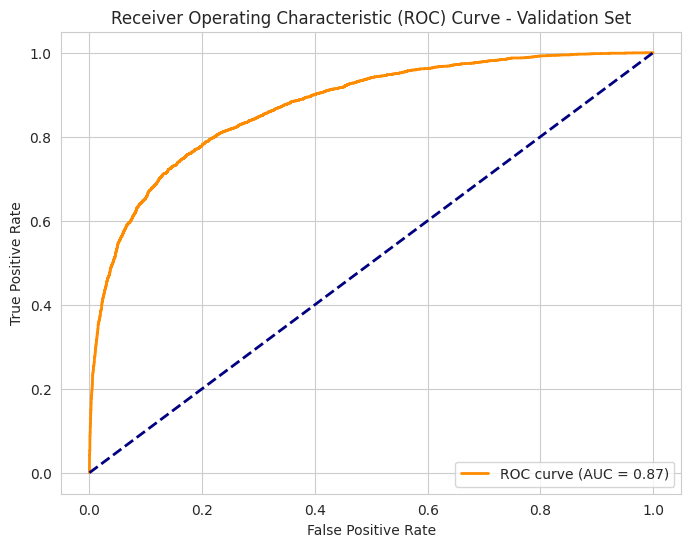

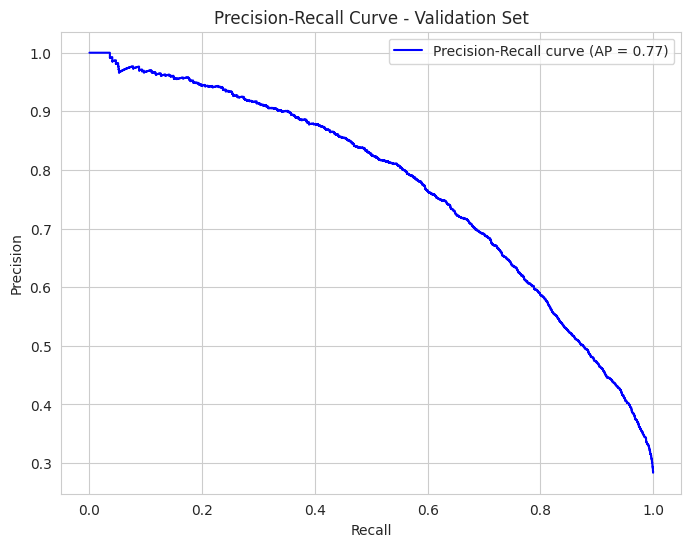

Area under ROC curve (AUC-ROC) for Verification Set: 0.87
Area under Precision-Recall curve (AUC-PR) for Verification Set: 0.77
Confusion Matrix for Validation Set:
[[7642  660]
 [1264 2020]]

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      8302
           1       0.75      0.62      0.68      3284

    accuracy                           0.83     11586
   macro avg       0.81      0.77      0.78     11586
weighted avg       0.83      0.83      0.83     11586



In [59]:
# Plot ROC curve for the verification set
plt.figure(figsize=(8, 6))
plt.plot(fpr_verify, tpr_verify, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_verify))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc='lower right')
plt.show()

# Plot precision-recall curve for the verification set
plt.figure(figsize=(8, 6))
plt.step(recall_verify, precision_verify, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision_verify))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.legend(loc='upper right')
plt.show()

print(f'Area under ROC curve (AUC-ROC) for Verification Set: {roc_auc_verify:.2f}')
print(f'Area under Precision-Recall curve (AUC-PR) for Verification Set: {average_precision_verify:.2f}')

# Generate confusion matrix and classification report for the verification set
cm_verify = confusion_matrix(y_verify, y_verify_pred)
cr_verify = classification_report(y_verify, y_verify_pred)

print("Confusion Matrix for Validation Set:")
print(cm_verify)

print("\nClassification Report for Validation Set:")
print(cr_verify)

In [60]:
# Assuming you have the true labels for the validation set
y_true = validation_data['los_type'].map({'Short': 0, 'Long': 1})

# Assuming 'validation_data' has predictions stored in 'y_verify_pred'
cm_verify = confusion_matrix(y_true, y_verify_pred)

# Extract values from the confusion matrix
tn, fp, fn, tp = cm_verify.ravel()

# Calculate equalized odds
equalized_odds_race = (tp / (tp + fn)) / (fp / (fp + tn))

print(equalized_odds_race)

7.737256856014469


In [61]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X = validation_data[numeric_columns]
y = validation_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y = y.map({'Short': 0, 'Long': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract insurance information for the test set
insurance_test = validation_data.loc[y_test.index, 'insurance']

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Combine predictions and insurance information into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Insurance': insurance_test})

# Assess performance for each insurance type
insurance_types = results_df['Insurance'].unique()
for insurance_type in insurance_types:
    subset = results_df[results_df['Insurance'] == insurance_type]
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {insurance_type} insurance:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for Medicare insurance:
Confusion Matrix:
[[670  61]
 [131 195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87       731
           1       0.76      0.60      0.67       326

    accuracy                           0.82      1057
   macro avg       0.80      0.76      0.77      1057
weighted avg       0.81      0.82      0.81      1057


--------------------------------------------------

Results for Other insurance:
Confusion Matrix:
[[704  67]
 [131 173]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       771
           1       0.72      0.57      0.64       304

    accuracy                           0.82      1075
   macro avg       0.78      0.74      0.76      1075
weighted avg       0.81      0.82      0.81      1075


--------------------------------------------------

Results for Medicaid insurance:
Confusion Matrix:

In [62]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X = validation_data[numeric_columns]
y = validation_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y = y.map({'Short': 0, 'Long': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract insurance information for the test set
insurance_test = validation_data.loc[y_test.index, 'insurance']

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Combine predictions and insurance information into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Insurance': insurance_test})

# Assess performance for each insurance type
insurance_types = results_df['Insurance'].unique()

for insurance_type in insurance_types:
    subset = results_df[results_df['Insurance'] == insurance_type]
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {insurance_type} insurance:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    # Calculate Type 1 and Type 2 errors
    type1_error = cm[0, 1]  # False Positives
    type2_error = cm[1, 0]  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")

    print('\n' + '-'*50 + '\n')

Results for Medicare insurance:
Confusion Matrix:
[[670  61]
 [131 195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87       731
           1       0.76      0.60      0.67       326

    accuracy                           0.82      1057
   macro avg       0.80      0.76      0.77      1057
weighted avg       0.81      0.82      0.81      1057

Type 1 Error (False Positives): 61
Type 2 Error (False Negatives): 131

--------------------------------------------------

Results for Other insurance:
Confusion Matrix:
[[704  67]
 [131 173]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       771
           1       0.72      0.57      0.64       304

    accuracy                           0.82      1075
   macro avg       0.78      0.74      0.76      1075
weighted avg       0.81      0.82      0.81      1075

Type 1 Error (False Positives):

In [63]:
# Columns to exclude from features
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'race', 'PHYSICIAN REFERRAL']

# Define your feature columns (exclude certain columns)
feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Exclude non-numeric columns before scaling
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X = validation_data[numeric_columns]
y = validation_data['los_type']

# Convert 'Short' and 'Long' to numerical labels (0 and 1)
y = y.map({'Short': 0, 'Long': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract insurance information for the test set
race_test = validation_data.loc[y_test.index, 'race']

# Standardize the features if needed (optional but often beneficial)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Combine predictions and insurance information into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Race': race_test})

# Assess performance for each race type
for race_type in race_types:
    subset = results_df[results_df['Race'] == race_type]
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {race_type} race:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for WHITE race:
Confusion Matrix:
[[1047   95]
 [ 189  254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1142
           1       0.73      0.57      0.64       443

    accuracy                           0.82      1585
   macro avg       0.79      0.75      0.76      1585
weighted avg       0.81      0.82      0.81      1585


--------------------------------------------------

Results for OTHER race:
Confusion Matrix:
[[188  19]
 [ 41  72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       207
           1       0.79      0.64      0.71       113

    accuracy                           0.81       320
   macro avg       0.81      0.77      0.78       320
weighted avg       0.81      0.81      0.81       320


--------------------------------------------------

Results for BLACK/AFRICAN AMERICAN race:
Confusion Matrix:

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
